# Implementing Our First Support Vector Machine

In order to understand how SVMs work, we have to think about **decision boundaries**.

When we used linear classifiers or decision trees in earlier chapters, our goal was always to
minimize the classification error. We did this by accuracy or mean squared error. An SVM
tries to achieve low classification errors too, but it does so only implicitly. An SVM's explicit
objective is to maximize the **margins** between data points of one class versus the other. This
is the reason SVMs are sometimes also called **maximum-margin classifiers**.

> For a detailed treatment of SVMs and how they work, please refer to the book.

For our very first SVM, we should
probably focus on a simple dataset, perhaps a binary classification task.

## Generating the dataset

A cool trick about scikit-learn's dataset module that I haven't told you about is that you can
generate random datasets of controlled size and complexity. A few notable ones are:
- `datasets.make_classification([n_samples, ...])`: This function generates a random $n$-class classification problem, where we can specify the number of samples, the number of features, and the number of target labels 
- `datasets.make_regression([n_samples, ...])`: This function generates a random regression problem
- `datasets.make_blobs([n_samples, n_features, ...])`: This function generates a number of Gaussian blobs we can use for clustering

This means that we can use `make_classification` to build a custom dataset for a binary
classification task.

For the sake of simplicity, let's limit ourselves to only two
feature values (`n_features=2`; for example, an $x$ and a $y$ value). Let's say we want to create
100 data samples:

In [1]:
from sklearn import datasets
X, y = datasets.make_classification(n_samples=100, n_features=2,
                                    n_redundant=0, n_classes=2,
                                    random_state=7816)

We expect `X` to have 100 rows (data samples) and two columns (features), whereas the
vector `y` should have a single column that contains all the target labels:

In [2]:
X.shape, y.shape

((100, 2), (100,))

## Visualizing the dataset

We can plot these data points in a scatter plot using Matplotlib. Here, the idea is to plot the
$x$ values (found in the first column of `X`, `X[:, 0]`) against the $y$ values (found in the second
column of `X`, `X[:, 1]`). A neat trick is to pass the target labels as color values (`c=y`):

Text(0, 0.5, 'y values')

<Figure size 640x480 with 0 Axes>

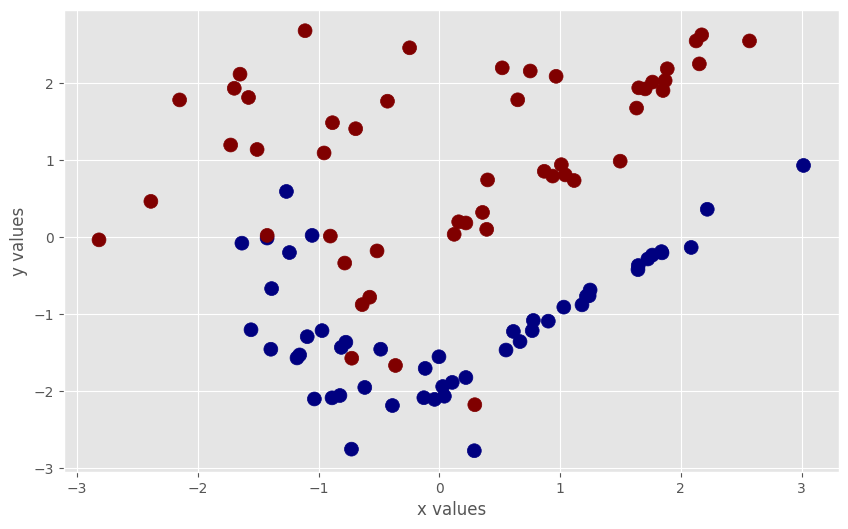

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.set_cmap('jet')
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=100)
plt.xlabel('x values')
plt.ylabel('y values')

You can see that, for the most part, data points of the two classes are clearly separated.
However, there are a few regions (particularly near the left and bottom of the plot) where
the data points of both classes intermingle. These will be hard to classify correctly, as we
will see in just a second.

## Preprocessing the dataset

The next step is to split the data points into training and test sets, as we have done before.
But, before we do that, we have to prepare the data for OpenCV:
- All feature values in `X` must be 32-bit floating point numbers
- Target labels must be either -1 or +1

We can achieve this with the following code:

In [4]:
import numpy as np
X = X.astype(np.float32)
y = y * 2 - 1

Now we can pass the data to scikit-learn's `train_test_split` function, like we did in the
earlier chapters:

In [5]:
from sklearn import model_selection as ms
X_train, X_test, y_train, y_test = ms.train_test_split(
    X, y, test_size=0.2, random_state=42
)

Here I chose to reserve 20 percent of all data points for the test set, but you can adjust this
number according to your liking.

## Building the support vector machine

In OpenCV, SVMs are built, trained, and scored the same exact way as every other learning
algorithm we have encountered so far, using the following steps.

Call the `create` method to construct a new SVM:

In [6]:
import cv2
svm = cv2.ml.SVM_create()

As shown in the following command, there are different *modes* in which we can
operate an SVM. For now, all we care about is the case we discussed in the
previous example: an SVM that tries to partition the data with a straight line. This
can be specified with the `setKernel` method:

In [7]:
svm.setKernel(cv2.ml.SVM_LINEAR)

Call the classifier's `train` method to find the optimal decision boundary:

In [8]:
svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train);

Call the classifier's `predict` method to predict the target labels of all data
samples in the test set:

In [9]:
_, y_pred = svm.predict(X_test)

Use scikit-learn's `metrics` module to score the classifier:

In [10]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.8

Congratulations, we got 80 percent correctly classified test samples!

Of course, so far we have no idea what happened under the hood. For all we know, we
might as well have gotten these commands off a web search and typed them into the
terminal, without really knowing what we're doing. But this is not who we want to be.

Getting a system to work is one thing and understanding it is another. Let us get to that!

## Visualizing the decision boundary

What was true in trying to understand our data is true for trying to understand our
classifier: visualization is the first step in understanding a system. We know the SVM
somehow came up with a decision boundary that allowed us to correctly classify 80 percent
of the test samples. But how can we find out what that decision boundary actually looks
like?

For this, we will borrow a trick from the guys behind scikit-learn. The idea is to generate a
fine grid of $x$ and $y$ coordinates and run that through the SVM's `predict` method. This will
allow us to know, for every $(x, y)$ point, what target label the classifier would have
predicted.

We will do this in a dedicated function, which we call `plot_decision_boundary`. The
function takes as inputs an SVM object, the feature values of the test set, and the target
labels of the test set. The function then creates a contour plot, on top of which we will plot the individual data points colored
by their true target labels:

In [11]:
def plot_decision_boundary(svm, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_hypo = np.c_[xx.ravel().astype(np.float32),
                   yy.ravel().astype(np.float32)]
    _, zz = svm.predict(X_hypo)
    zz = zz.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

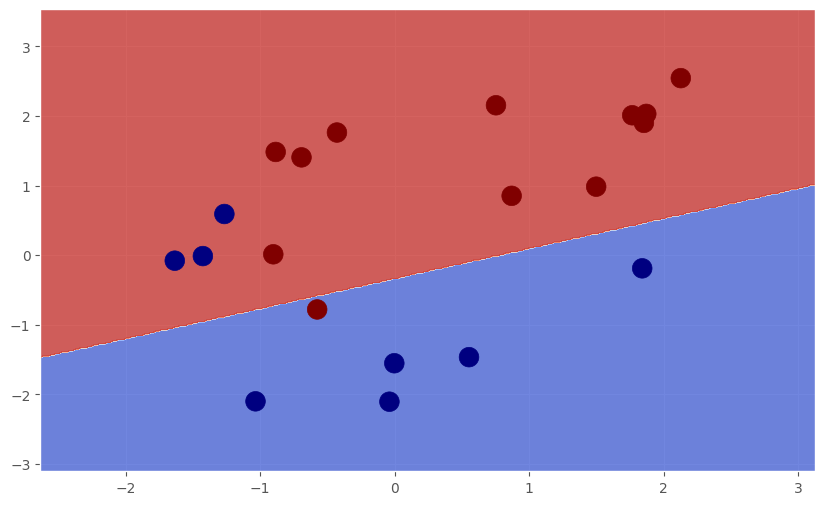

In [12]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(svm, X_test, y_test)

Now we get a better sense of what is going on!

The SVM found a straight line (a **linear decision boundary**) that best separates the blue and
the red data samples. It didn't get all the data points right, as there are three blue dots in the
red zone and one red dot in the blue zone.

However, we can convince ourselves that this is the best straight line we could have chosen
by wiggling the line around in our heads. If you're not sure why, please refer to the book (p. 148).

So what can we do to improve our classification performance?

One solution is to move away from straight lines and onto more complicated decision
boundaries.

# Dealing with nonlinear decision boundaries

What if the data cannot be optimally partitioned using a linear decision boundary? In such
a case, we say the data is not linearly separable.

The basic idea to deal with data that is not linearly separable is to create **nonlinear
combinations** of the original features. This is the same as saying we want to project our
data to a higher-dimensional space (for example, from 2D to 3D) in which the data
suddenly becomes linearly separable.

The book has a nice figure illustrating this idea.

## Implementing nonlinear support vector machines

OpenCV provides a whole range of different SVM kernels with which we can experiment.

Some of the most commonly used ones include:
- `cv2.ml.SVM_LINEAR`: This is the kernel we used previously. It provides a linear decision boundary in the original feature space (the $x$ and $y$ values).
- `cv2.ml.SVM_POLY`: This kernel provides a decision boundary that is a polynomial function in the original feature space. In order to use this kernel, we also have to specify a coefficient via `svm.setCoef0` (usually set to 0) and the degree of the polynomial via `svm.setDegree`.
- `cv2.ml.SVM_RBF`: This kernel implements the kind of Gaussian function we discussed earlier.
- `cv2.ml.SVM_SIGMOID`: This kernel implements a sigmoid function, similar to the one we encountered when talking about logistic regression in [Chapter 3](03.00-First-Steps-in-Supervised-Learning.ipynb), *First Steps in Supervised Learning*.
- `cv2.ml.SVM_INTER`: This kernel is a new addition to OpenCV 3. It separates classes based on the similarity of their histograms.

In order to test some of the SVM kernels we just talked about, we will return to our code
sample mentioned earlier. We want to repeat the process of building and training the SVM
on the dataset generated earlier, but this time we want to use a whole range of different
kernels:

In [13]:
kernels = [cv2.ml.SVM_LINEAR, cv2.ml.SVM_INTER, cv2.ml.SVM_SIGMOID, cv2.ml.SVM_RBF]

Do you remember what all of these stand for?

Setting a different SVM kernel is relatively simple. We take an entry from the kernels list
and pass it to the setKernels method of the SVM class. That's all.

The laziest way to repeat things is to use a for loop:

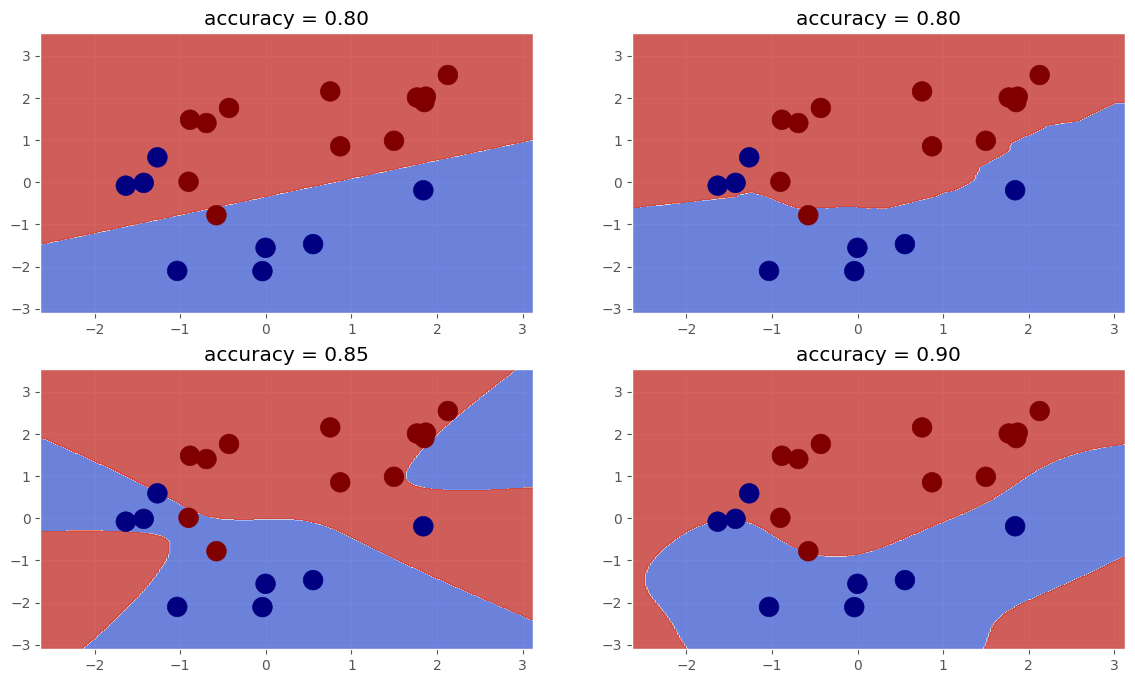

In [14]:
plt.figure(figsize=(14, 8))
for idx, kernel in enumerate(kernels):
    svm = cv2.ml.SVM_create()
    svm.setKernel(kernel)
    svm.train(X_train, cv2.ml.ROW_SAMPLE, y_train)
    _, y_pred = svm.predict(X_test)
    
    plt.subplot(2, 2, idx + 1)
    plot_decision_boundary(svm, X_test, y_test)
    plt.title('accuracy = %.2f' % metrics.accuracy_score(y_test, y_pred))

Let's break the figure down step-by-step:

First, we find that the linear kernel (top-left panel) still looks like one in an earlier plot. We
now realize that it's also the only version of SVM that produces a straight line as a decision
boundary (although `cv2.ml.SVM_C` produces almost identical results to
`cv2.ml.SVM_LINEAR`).

The histogram intersection kernel (top-right panel) allows for a more complex decision
boundary. However, this did not improve our generalization performance (accuracy is still
at 80 percent).

Although the sigmoid kernel (bottom-left panel) allows for a nonlinear decision boundary,
it made a really poor choice, leading to only 25% accuracy.

On the other hand, the Gaussian kernel (bottom-right panel) was able to improve our
performance to 90% accuracy. It did so by having the decision boundary wrap around the
lowest red dot and reaching up to put the two leftmost blue dots into the blue zone. It still
makes two mistakes, but it definitely draws the best decision boundary we have seen to
date! Also, note how the RBF kernel is the only kernel that cares to narrow down the blue
zone in the lower two corners.